In [ ]:
library(Seurat)
library(ggplot2)
library(tidyr)
library(cowplot)
library(aplot)
library(patchwork)
library(ggtree)
library(dplyr)
library(stringr)
library(ggpubr)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 
Attaching SeuratObject

Attaching package: ‘patchwork’

The following object is masked from ‘package:cowplot’:

    align_plots

ggtree v3.6.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96

Shuangbin Xu, Lin Li, Xiao Luo

In [ ]:
### Parameters cell ###
## Load in Seurat object ### -- make sure preprocessing and the RunPCA function has been run on the Seurat data
adata.R = readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_integrated_seurat.rds') ### parameter -- path to Seurat object
meta = adata.R@meta.data
meta$guide = meta$miR.family ### parameter -- switch out 'miR.family' here for name of column containing sample identifiers for each cell
## make sure that the sample name for the control celss is 'TuD_NC' for script to work
savepath = '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/' ## edit this path to save the output files

In [ ]:
scaled_scores <- scale(Embeddings(adata.R, reduction = "pca"))
var_rot <- varimax(Loadings(adata.R, reduction = "pca"))$rotmat
rotated_varimax_scores <- scaled_scores %*% var_rot ## these are the coordinates of the cell in rotated component space

In [ ]:
vari_weights = varimax(Loadings(adata.R, reduction = "pca"))
vari_weights = vari_weights$loadings ## these are the weights of genes for each component in the rotated component space
vari_weights[1:5,1:5]

              PC_1        PC_2         PC_3          PC_4          PC_5
IFIT2 -0.010907453 0.002815424  0.011872409 -0.0044128251 -0.0038884464
IFIT3 -0.003904446 0.007061878  0.007961426  0.0000171365 -0.0037172346
IFIT1  0.005096107 0.001910319  0.000452338 -0.0060331203  0.0008821542
OASL  -0.003059867 0.004559411  0.019185094  0.0017159237 -0.0014871808
CDH1  -0.001087855 0.002699645 -0.006597429  0.0058225829  0.0020660979


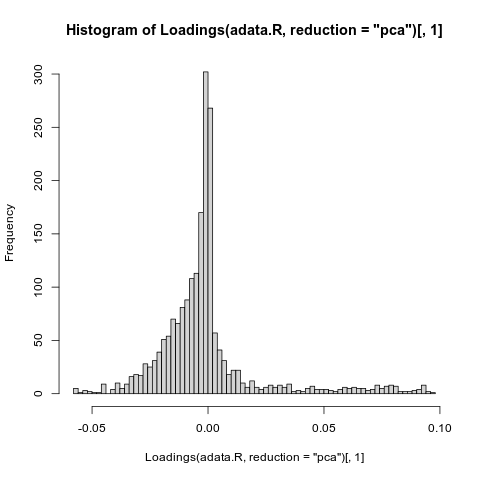

In [ ]:
## genes with high weights in PC1 from original PCA
hist(Loadings(adata.R, reduction = "pca")[,1], breaks = 100, main = 'Principal Component 1 Cell Coordinates', xlab = 'Coordinates')

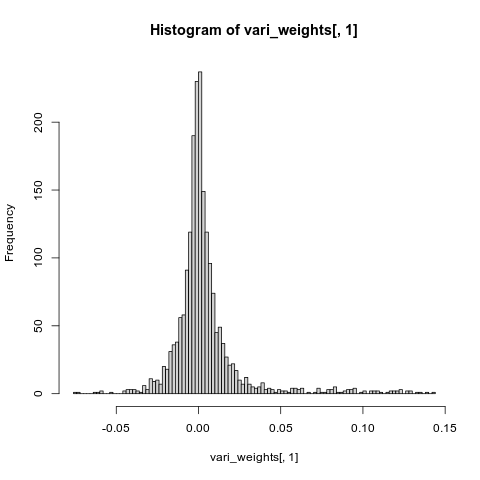

In [ ]:
## genes with high weights in PC1 from varimax rotation
hist(vari_weights[,1], breaks = 100, main = 'Rotated Component 1 Weights', xlab = 'Weights')

In [ ]:
## build linear model between rotated scores and cell guide identity, pick best fit model for each PC from log likelihood ratio test p-value

uniq = unique(meta$guide)
fitted_models = list()
fit_pvals = list()
pb = txtProgressBar(min = 0, max = ncol(rotated_varimax_scores), style = 3)
for (j in 1:ncol(rotated_varimax_scores)){
    fitted_models[[j]] <- lapply(as.list(uniq), function(x) glm(identity ~ scores, data = data.frame(scores = rotated_varimax_scores[meta$guide == x | meta$guide == 'TuD_NC',j], identity = factor(meta$guide[meta$guide == x | meta$guide == 'TuD_NC'] == x)), family = 'binomial'))
    fit_pvals[[j]] = lapply(fitted_models[[j]], function(x) with(x, pchisq(null.deviance - deviance, df.null - df.residual, lower.tail = FALSE)))
    setTxtProgressBar(pb, j)
}
close(pb)

  |======================================================================| 100%


In addition: There were 50 or more warnings (use warnings() to see the first 50)


In [ ]:
fit_pvals_adj = lapply(fit_pvals, function(x) p.adjust(as.numeric(unlist(x)), method = 'BH'))
fit_pvals_adj = lapply(fit_pvals_adj, function(x) -log10(x))

In [ ]:
save(fitted_models, fit_pvals, fit_pvals_adj, file = paste0(savepath, 'samples_varimax_rot_logit_fit_data_compare_to_controls_only.RData'))

In [ ]:
#load(paste0(savepath, 'samples_varimax_rot_logit_fit_data_compare_to_controls_only.RData'))

NULL


In [ ]:
save(fit_pvals, fit_pvals_adj, file = paste0(savepath, 'samples_varimax_rot_logit_fit_data_pvals_only_compare_to_controls_only.RData'))

In [ ]:
load(paste0(savepath, 'samples_varimax_rot_logit_fit_data_pvals_only_compare_to_controls_only.RData'))

In [ ]:
uniq = unique(meta$guide)
df = data.frame(matrix(unlist(fit_pvals_adj), nrow = length(fit_pvals_adj), byrow = T))
colnames(df) = uniq
df$y = paste0('RC', 1:ncol(rotated_varimax_scores))
df_long <- pivot_longer(df, cols = -c(y), names_to = 'x', values_to = 'value')
d <- as.data.frame(df_long)
head(d)

    y

                        x       value
1 RC1            miR-203a-3p.1 0.002680519
2 RC1                miR-93-3p 0.004495816
3 RC1 miR-130-3p/301-3p/454-3p 0.004495816
4 RC1                   TuD_NC 0.000000000
5 RC1                 miR-147b 0.004495816
6 RC1               miR-501-5p 0.004495816


In [ ]:
dim(df)

[1]  50 337


In [ ]:
d2 = d
#d2$x = str_sub(d2$x, 1, 25)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 13104 rows containing missing values (`geom_tile()`). 



the plot was flipped and the x limits will be applied to y-axis
In addition: Warning message:
Removed 13104 rows containing missing values (`geom_tile()`). 


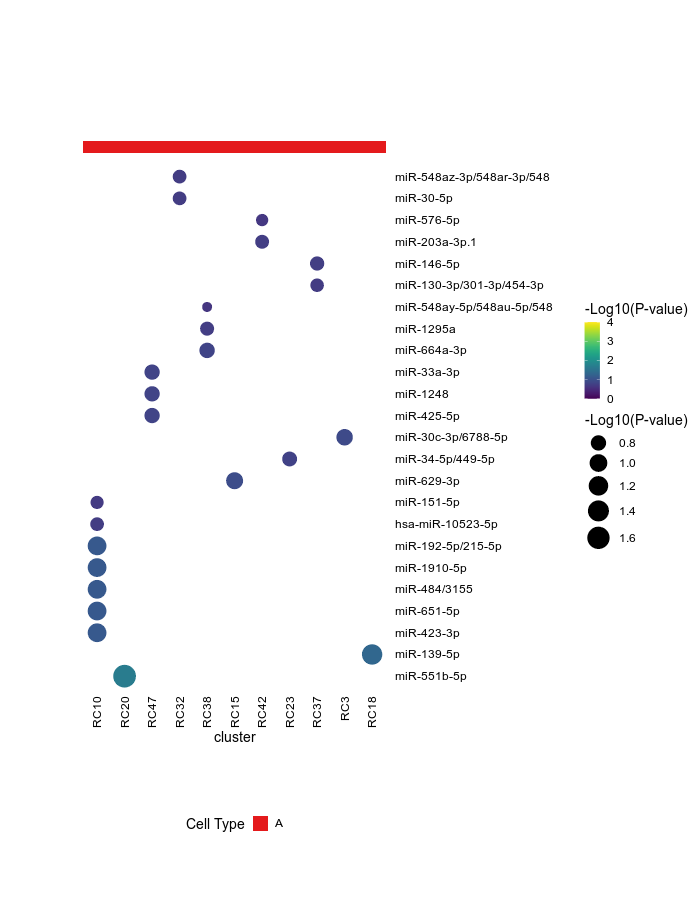

In [ ]:
gene_cluster = d2
colnames(gene_cluster) = c('cluster', 'Gene', 'count')

# make data square to calculate euclidean distance
mat <- gene_cluster %>% # drop unused columns to faciliate widening
  pivot_wider(names_from = cluster, values_from = count) %>%
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Gene  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(count > (-log10(0.25))) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = count)) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(0,4), oob = scales::squish, name = '-Log10(P-value)') +
  scale_size_continuous(name = '-Log10(P-value)', range = c(4,10)) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))

In [ ]:
ggsave(paste0(savepath, 'samples_varimax_rot_logit_fit_plot_compare_to_controls_only_9x12.pdf'), width = 9, height = 12)

In addition: Warning messages:
1: Removed 13104 rows containing missing values (`geom_tile()`). 
2: Removed 13104 rows containing missing values (`geom_tile()`). 
3: Removed 13104 rows containing missing values (`geom_tile()`). 
4: Removed 13104 rows containing missing values (`geom_tile()`). 
5: Removed 13104 rows containing missing values (`geom_tile()`). 
6: Removed 13104 rows containing missing values (`geom_tile()`). 


In [ ]:
## save significant RCs
significant_RCs = gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(count > (-log10(0.25))) %>% select(cluster) %>% unique()

significant_RCs = as.character(significant_RCs$cluster)
saveRDS(significant_RCs, paste0(savepath, 'samples_significant_RCs.rds'))

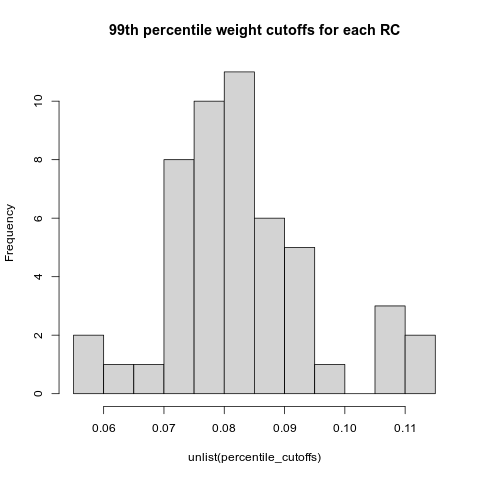

In [ ]:
## graph the samples in the clusters and pick out those with positive correlations (ie PC scores associated with that particular sample)
## pick out genes associated with significant weights (above 99th percentile for each PC -- basically top 20 genes for each PC)

percentile_cutoffs = apply(abs(vari_weights), 2, quantile, probs = 0.99)
genes_passing_cutoff = lapply(1:ncol(vari_weights), function(x) names(vari_weights[,x])[which(abs(vari_weights[,x]) > percentile_cutoffs[x])])
names(genes_passing_cutoff) = paste0('RC', 1:ncol(vari_weights))

hist(unlist(percentile_cutoffs), breaks = 10, main = '99th percentile weight cutoffs for each RC')

In [ ]:
## replace with zero all below cutoffs
zero_below_thresh <- function(df, cutoffs){
    df = as.matrix(df)
    for (i in 1:ncol(df)){
    df[,i][abs(df[,i]) < cutoffs[i]] = 0
    colnames(df)[i] = paste0('RC', i)
    }
    return(df)
}

vari_weights_abv_thresh = zero_below_thresh(vari_weights, percentile_cutoffs)
vari_weights_abv_thresh2 = zero_below_thresh(vari_weights, rep(0.1, ncol(vari_weights)))

In [ ]:
vari_weights_abv_thresh = data.frame(matrix(as.numeric(vari_weights_abv_thresh), attributes(vari_weights_abv_thresh)$dim, dimnames=attributes(vari_weights_abv_thresh)$dimnames))
vari_weights_abv_thresh$y = rownames(vari_weights_abv_thresh)
weights_df <- pivot_longer(vari_weights_abv_thresh, cols = -c(y), names_to = 'x', values_to = 'value')
weights_df <- as.data.frame(weights_df)
head(weights_df)

      y   x value
1 IFIT2 RC1     0
2 IFIT2 RC2     0
3 IFIT2 RC3     0
4 IFIT2 RC4     0
5 IFIT2 RC5     0
6 IFIT2 RC6     0


In [ ]:
## this is used in manuscript -- genes with loadings above 0.1 kept for each RC for pathway analysis
vari_weights_abv_thresh2 = data.frame(matrix(as.numeric(vari_weights_abv_thresh2), attributes(vari_weights_abv_thresh2)$dim, dimnames=attributes(vari_weights_abv_thresh2)$dimnames))
vari_weights_abv_thresh2$y = rownames(vari_weights_abv_thresh2)
weights_df2 <- pivot_longer(vari_weights_abv_thresh2, cols = -c(y), names_to = 'x', values_to = 'value')
weights_df2 <- as.data.frame(weights_df2)
head(weights_df2)

      y   x value
1 IFIT2 RC1     0
2 IFIT2 RC2     0
3 IFIT2 RC3     0
4 IFIT2 RC4     0
5 IFIT2 RC5     0
6 IFIT2 RC6     0


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 82000 rows containing missing values (`geom_tile()`). 



the plot was flipped and the x limits will be applied to y-axis
In addition: Warning message:
Removed 82000 rows containing missing values (`geom_tile()`). 


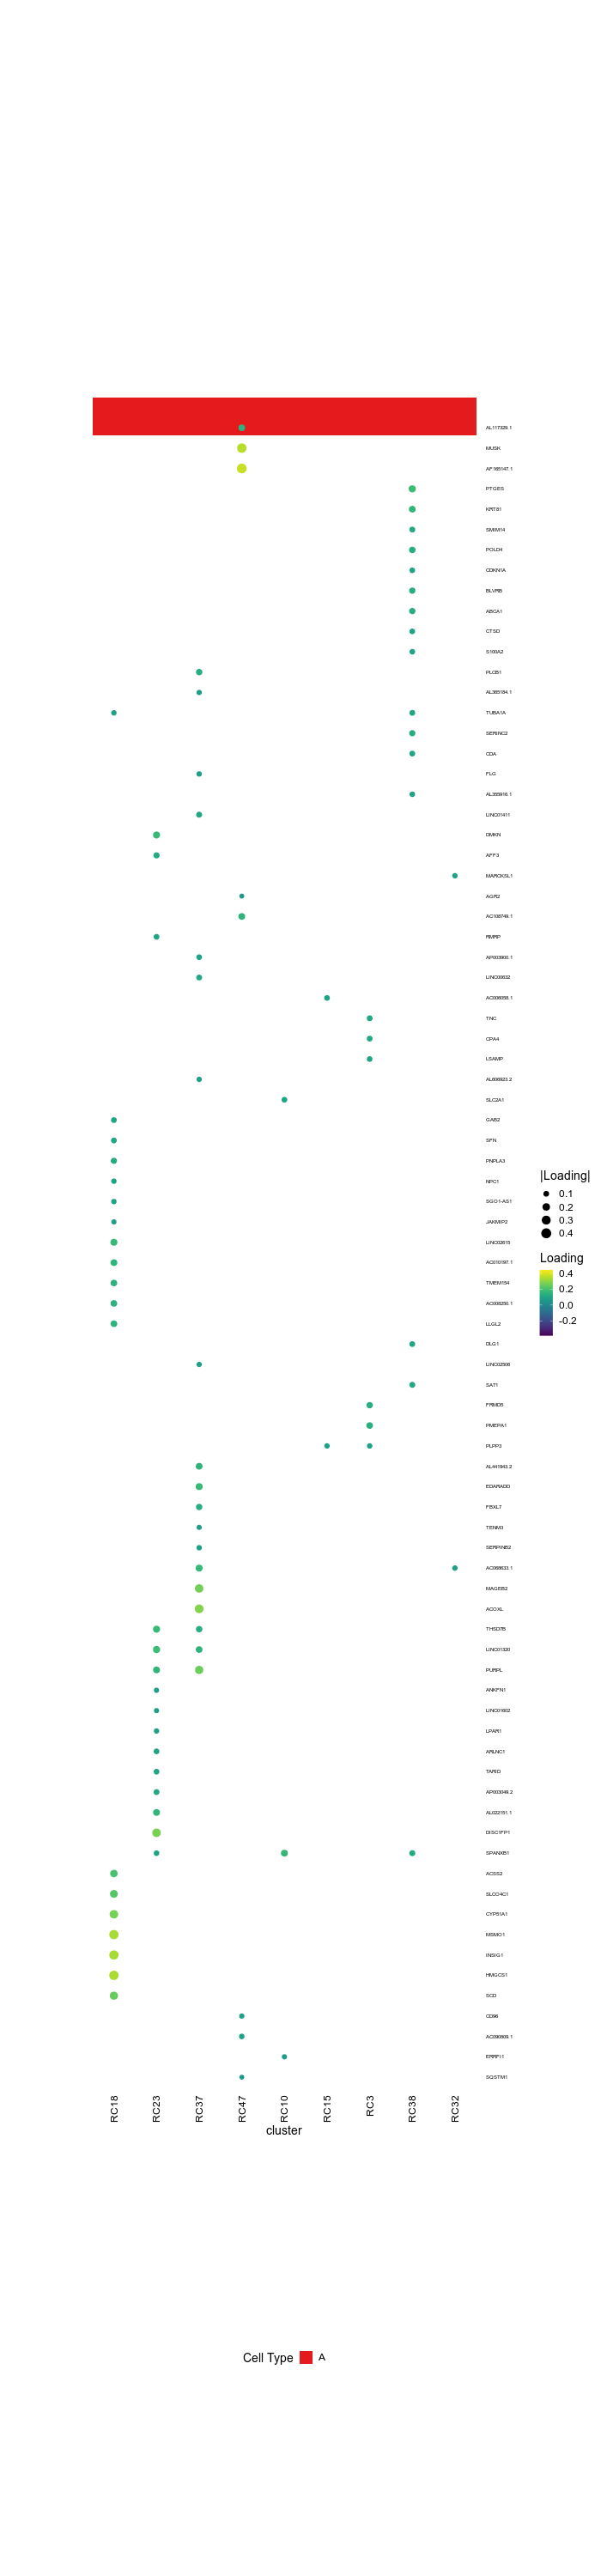

In [ ]:
## genes with weights above 99th percentile for each RC shown

gene_cluster = weights_df
colnames(gene_cluster) = c('Gene', 'cluster', 'count')

# make data square to calculate euclidean distance
mat <- gene_cluster %>% # drop unused columns to faciliate widening
  pivot_wider(names_from = cluster, values_from = count) %>%
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Gene  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(count > 0) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = abs(count))) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_text(size = 6)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(min(gene_cluster$count), max(gene_cluster$count)), oob = scales::squish, name = 'Loading') +
  scale_size_continuous(name = '|Loading|', range = c(0.2,5), limits = c(0.0001, max(gene_cluster$count))) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))

In [ ]:
gene_cluster = weights_df2
colnames(gene_cluster) = c('Gene', 'cluster', 'count')
gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(count > 0) %>% select(cluster) %>% unique()

   cluster
1     RC23
2     RC37
4     RC38
9     RC47
23    RC18
26     RC3
49    RC10


In [ ]:
significant_RCs

 [1] "RC3"  "RC10" "RC15" "RC18" "RC20" "RC23" "RC32" "RC37" "RC38" "RC42"
[11] "RC47"


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 78000 rows containing missing values (`geom_tile()`). 



the plot was flipped and the x limits will be applied to y-axis
In addition: Warning message:
Removed 78000 rows containing missing values (`geom_tile()`). 


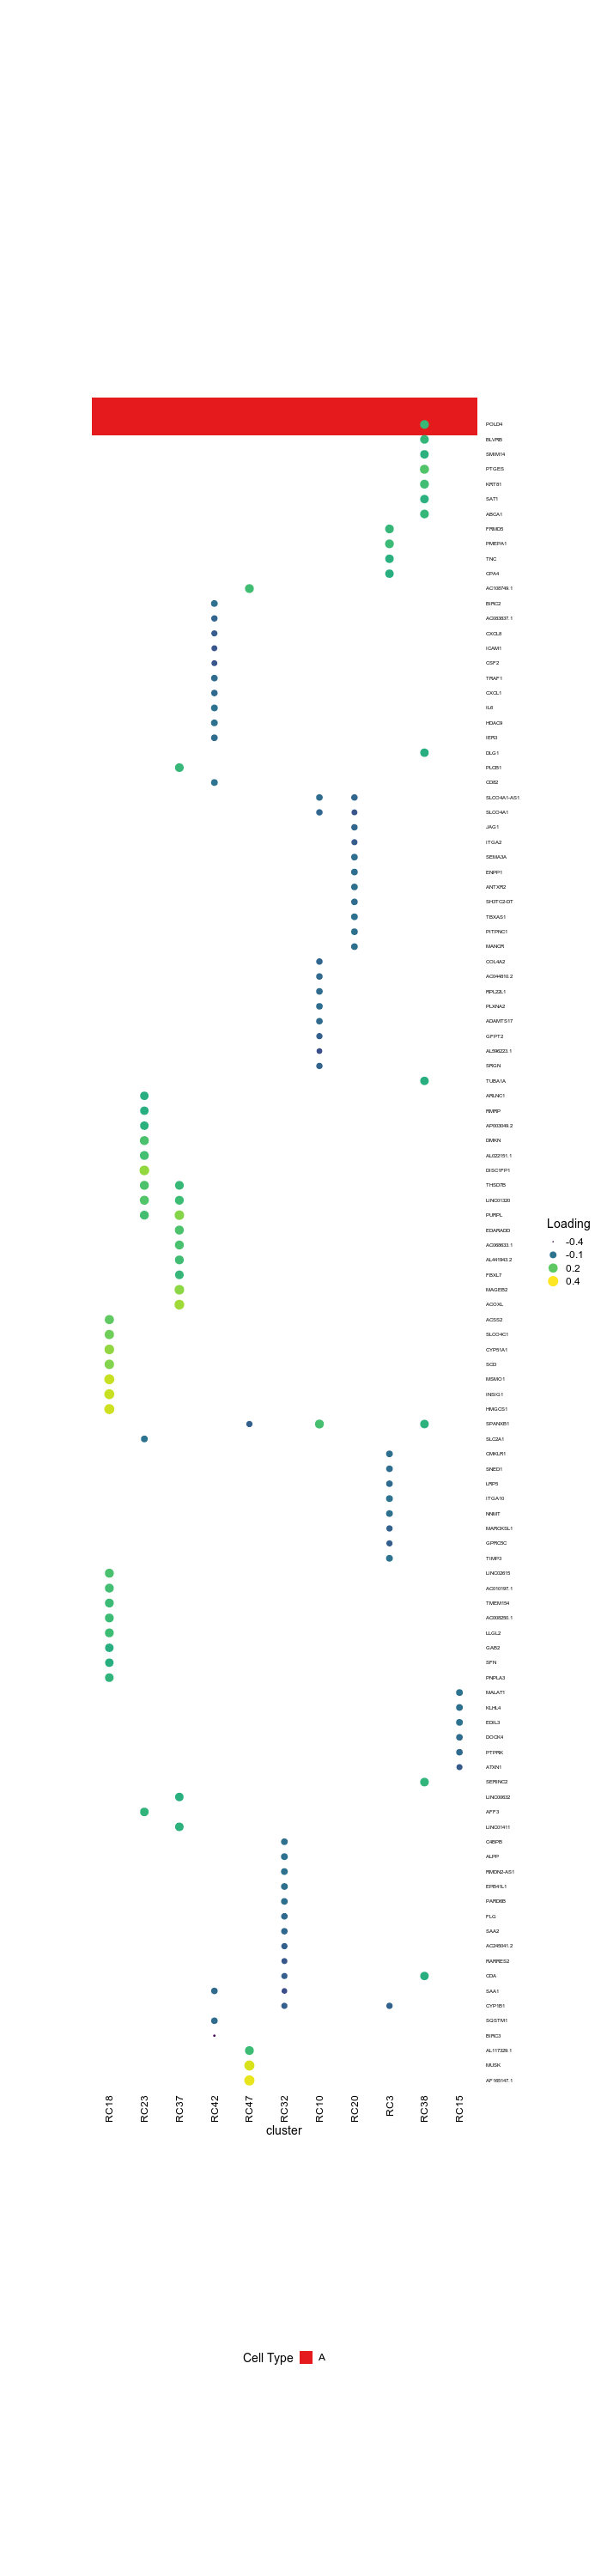

In [ ]:
## genes with weights above 0.1 loading weight for each RC shown

gene_cluster = weights_df2
colnames(gene_cluster) = c('Gene', 'cluster', 'count')

# make data square to calculate euclidean distance
mat <- gene_cluster %>% # drop unused columns to faciliate widening
  pivot_wider(names_from = cluster, values_from = count) %>%
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Gene  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(count > 0 | count < 0) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = count)) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_text(size = 6)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(guide = 'legend', name = 'Loading', colours = viridis::viridis(20), limits = c(round(min(gene_cluster$count), 1), round(max(gene_cluster$count), 1)), oob = scales::squish, breaks = round(seq(min(gene_cluster$count), max(gene_cluster$count), length.out = 4), 1)) +
  scale_size_continuous(guide = 'legend', name = 'Loading', range = c(0,5), limits = c(round(min(gene_cluster$count), 1), round(max(gene_cluster$count), 1)), breaks = round(seq(min(gene_cluster$count), max(gene_cluster$count), length.out = 4), 1)) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))

In [ ]:
ggsave(paste0(savepath, 'samples_varimax_rot_logit_fit_plot_compare_to_controls_only_gene_weights_4x15.pdf'), width = 4, height = 15)

In addition: Warning messages:
1: Removed 86000 rows containing missing values (`geom_tile()`). 
2: Removed 86000 rows containing missing values (`geom_tile()`). 
3: Removed 86000 rows containing missing values (`geom_tile()`). 
4: Removed 86000 rows containing missing values (`geom_tile()`). 
5: Removed 86000 rows containing missing values (`geom_tile()`). 
6: Removed 86000 rows containing missing values (`geom_tile()`). 
7: Removed 86000 rows containing missing values (`geom_tile()`). 


In [ ]:
## save genes of significant RCs
weights_df2_sig_genes = gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(abs(count) > 0) %>% arrange(cluster) %>% as.data.frame()

head(weights_df2_sig_genes)

        Gene cluster     count
1     HMGCS1    RC18 0.3406596
2 AC008250.1    RC18 0.1464315
3 AC010197.1    RC18 0.1566044
4        SCD    RC18 0.2488409
5        SFN    RC18 0.1038598
6    SLCO4C1    RC18 0.2219474


### Pathway analysis

In [ ]:
## do pathway analysis on genes w/loading > 0.1 of each significant RC
library(enrichR)
setEnrichrSite("Enrichr")
dbs <- c("GO_Molecular_Function_2021", "GO_Cellular_Component_2021", "GO_Biological_Process_2021")
dbs <- c("GO_Biological_Process_2021")

Welcome to enrichR
Checking connection ... 
Enrichr ... Connection is Live!
FlyEnrichr ... Connection is Live!
WormEnrichr ... Connection is Live!
YeastEnrichr ... Connection is Live!
FishEnrichr ... Connection is Live!
OxEnrichr ... Connection is Live!
Connection changed to https://maayanlab.cloud/Enrichr/
Connection is Live!


In [ ]:
list_convert <- function(n, df) {
    clusters = unique(df$cluster)
    filtered_df = df %>% filter(cluster == clusters[n])
    return(as.character(filtered_df$Gene))
}

In [ ]:
significant_genes_load_0.1 = lapply(1:length(unique(weights_df2_sig_genes$cluster)), list_convert, weights_df2_sig_genes)
names(significant_genes_load_0.1) = unique(weights_df2_sig_genes$cluster)

In [ ]:
## there is a problem with the enrichr package, it requries a delay between queries to prevent repeat results for earlier inputs
## make sure none are identical -- make sure all false at bottom of output of this cell
enriched_list = list()

for (i in 1:length(significant_genes_load_0.1)) {
    enriched_list[[i]] = enrichr(as.character(significant_genes_load_0.1[[i]]), dbs)
    Sys.sleep(1)
}
enriched_list = lapply(enriched_list, '[[', 1)
sapply(enriched_list[-1], function(x) identical(x,enriched_list[[1]]))

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  

In [ ]:
## get top 3 pathways for each RC
Terms = lapply(enriched_list, function(x) x %>% select(Term, Combined.Score) %>% arrange(desc(Combined.Score)) %>% pull(Term) %>% head(3))
Scores = lapply(enriched_list, function(x) x %>% select(Term, Combined.Score) %>% arrange(desc(Combined.Score)) %>% pull(Combined.Score) %>% head(3) %>% as.numeric())
adjacency_table = data.frame(pathways = unlist(Terms), components = as.character(sapply(names(significant_genes_load_0.1), rep, each = 3)), scores = unlist(Scores))

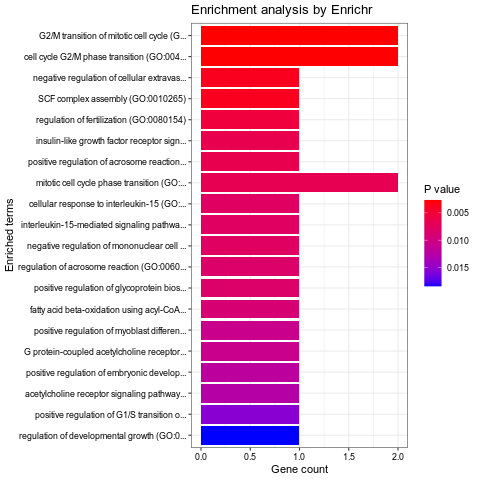

In [ ]:
plotEnrich(enriched_list[[3]], showTerms = 20, numChar = 40, y = "Count", orderBy = "P.value")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


the plot was flipped and the x limits will be applied to y-axis


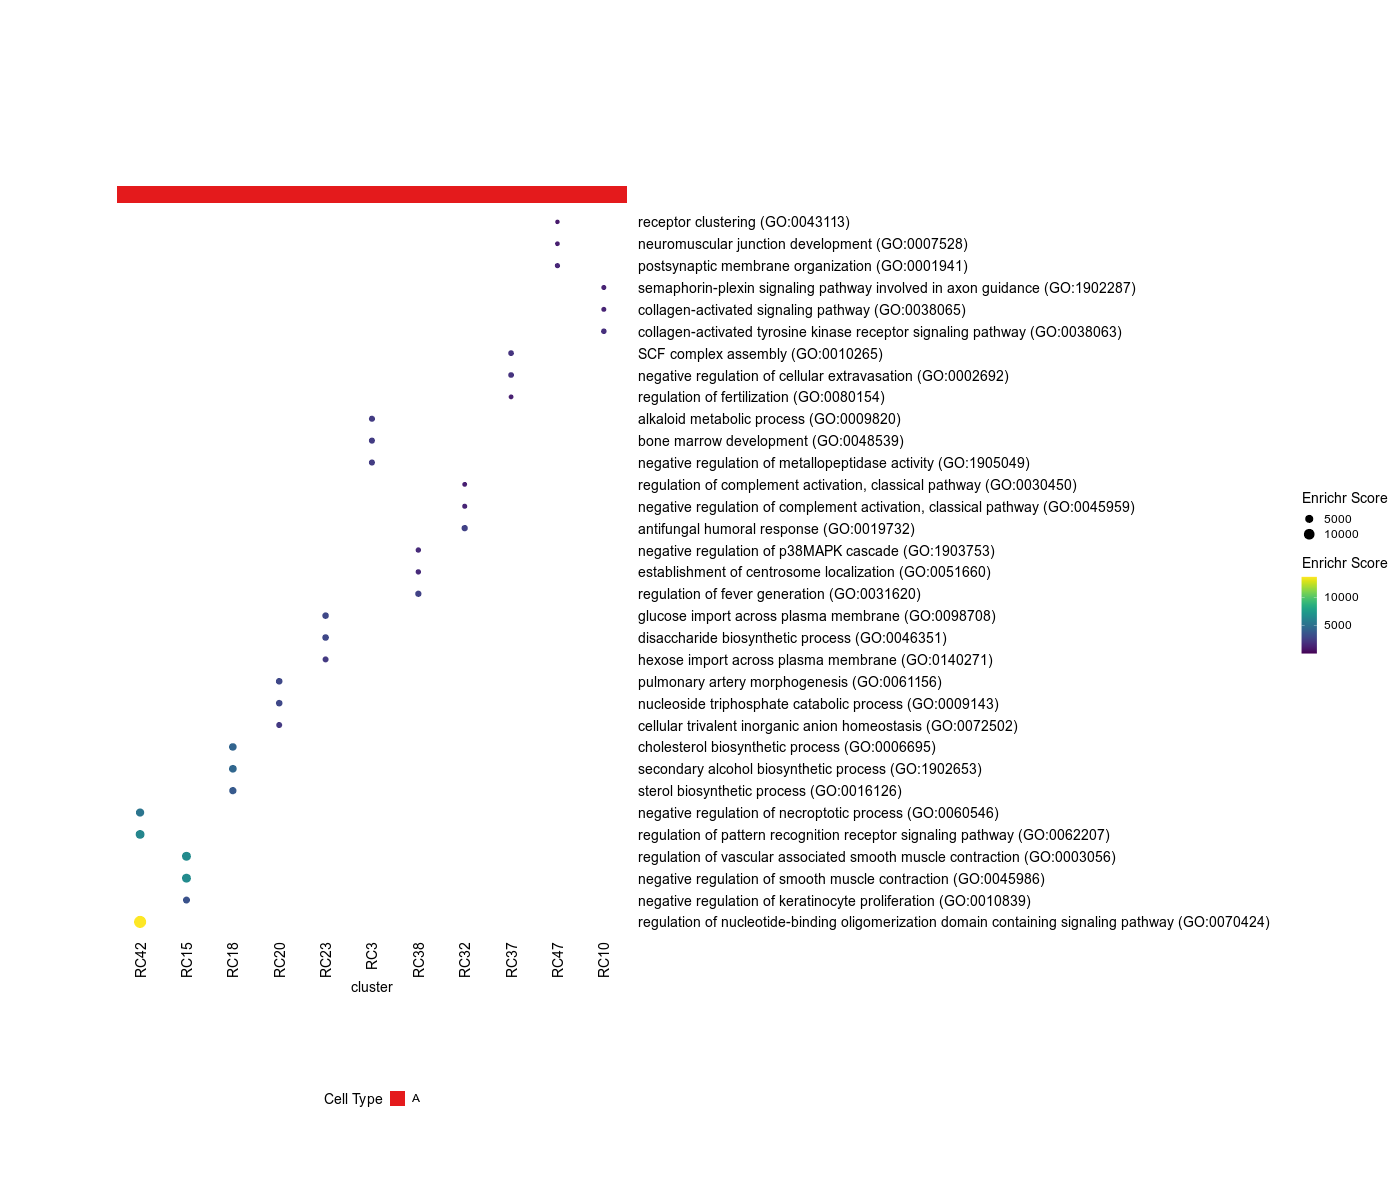

In [ ]:
gene_cluster = adjacency_table
colnames(gene_cluster) = c('Gene', 'cluster', 'count')

library(igraph)
mygraph <- graph_from_data_frame(gene_cluster)
mat <- as.matrix(get.adjacency(mygraph, sparse = FALSE, attr='count'))
mat <- select(as.data.frame(mat), starts_with("RC")) %>% filter(!startsWith(row.names(mat), "RC"))

clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(cluster %in% significant_RCs) %>% filter(count > 0) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = count)) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 14), axis.text.y = element_text(size = 14)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(0.0001, max(gene_cluster$count)), oob = scales::squish, name = 'Enrichr Score') +
  scale_size_continuous(name = 'Enrichr Score', range = c(0.2,5), limits = c(0.0001, max(gene_cluster$count))) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))


In [ ]:
ggsave(paste0(savepath, 'samples_varimax_rot_logit_fit_plot_compare_to_controls_only_pathways_14x10.pdf'), width = 14, height = 10)